In [2]:
from importlib import reload

import numpy as np
import scipy as sc
import pandas as pd
import editdistance

import torch
print(torch.cuda.is_available())

import utils
import shifts
import viennarna_shifts as vshifts
import tdre

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

/homefs/home/wongfanc/miniconda3/envs/viennaenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


2023-11-10 19:17:48.475153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 19:17:48.660460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-10 19:17:48.660493: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-10 19:18:06.163791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Waymark construction

In [2]:
reload(tdre)

# mixed dimensions
X0_nxd = np.zeros([2, 3])
Xm_nxd = np.ones([2, 3])
n_ratio = 3
X_m1xnxd = np.array([
    [[0., 0., 0.],
     [0., 0., 0.]],
    [[1., 0., 0.],
     [1., 0., 0.]],
    [[1., 1., 0.],
     [1., 1., 0.]],
    [[1., 1., 1.],
     [1., 1., 1.]]
])
result = tdre.get_mixed_dim_waymarks(X0_nxd, Xm_nxd, n_ratio)
assert((result == X_m1xnxd).all())

# alphas for linear mixing
a_m1 = np.array([0., np.sqrt(2) / 2, 1.])
result = tdre.get_alphas(2)
assert((result == a_m1).all())

# linear mixing waymarks
result = tdre.get_linear_waymarks(X0_nxd, Xm_nxd, a_m1)
X_m1xnxd = np.zeros([3, 2, 3])
X_m1xnxd[-1] = 1
X_m1xnxd[1] = np.sqrt(2) / 2
assert((result == X_m1xnxd).all())

Waymark 1 / 2 has 1, 2 dimensions from P0, Pm.
Waymark 2 / 2 has 2, 1 dimensions from P0, Pm.


# Distribution shifts

In [62]:
reload(shifts)
n_category = 3
seed_category_idx = 1
p_mutation = 0.1
dist_c = shifts.get_categorical_dist(n_category, seed_category_idx, p_mutation)
assert((dist_c == np.array([0.05, 0.9, 0.05])).all())

seq = 'AA'
p = 1
alphabet = 'AB'
mut = shifts.get_mutant(seq, p, alphabet)
assert(mut == 'BB')

seq = 'A'
p = 0.5
alphabet = 'ABC'
n_trial = 10000
frac_b = 0
frac_c = 0
for _ in range(n_trial):
    mut = shifts.get_mutant(seq, p, alphabet)
    if mut == 'B':
        frac_b += 1
    elif mut == 'C':
        frac_c += 1
frac_b /= n_trial
frac_c /= n_trial
assert(np.abs(frac_b - 0.25) <= 0.01)
assert(np.abs(frac_c - 0.25) <= 0.01)

## FLEXS baseline explorer with WT-centered training data

In [2]:
reload(vshifts)
n_train = 10000
thresh = 0.3
explorer_kwargs = { 
    'mu': 1, 'threshold': thresh
}
landscape_name = 'L14_RNA1'

model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead
flexsshift = vshifts.FLEXSShift(landscape_name)
trainseqs_n, ytrain_n, testseqs_m, ytest_m, predtest_m = flexsshift.get_data(
    n_train,
    model_class,
    explorer_class,
    explorer_kwargs,
    seed_idx=1,
    avg_n_mut=2
)
assert(len(trainseqs_n) == len(testseqs_m))

# test training sequences
nmut_n = np.array([editdistance.eval(flexsshift.problem['starts'][1], s) for s in trainseqs_n])
assert(np.abs(np.mean(nmut_n) - 2) <= 0.05)

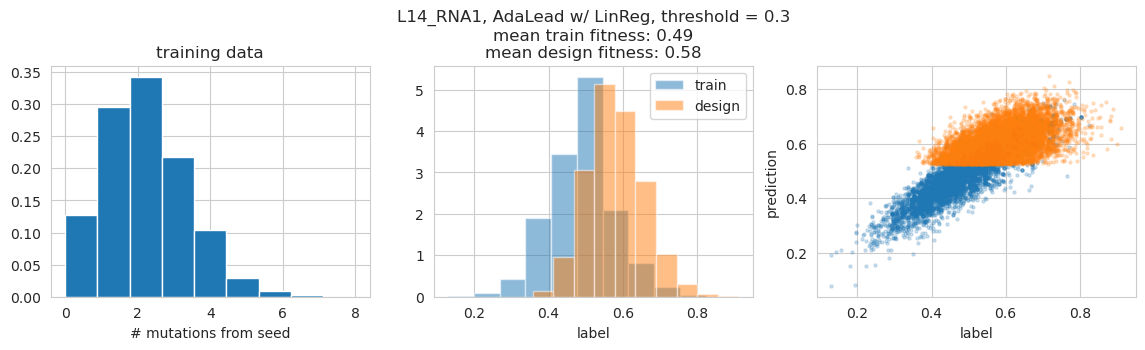

In [3]:
predtrain_n =  flexsshift.explorer.model.get_fitness(trainseqs_n)

plt.figure(figsize=(14, 3));
plt.subplot(131)
plt.hist(nmut_n, density=True, bins=9);
plt.xlabel('# mutations from seed');
plt.title('training data');

plt.subplot(132)
plt.hist(ytrain_n, alpha=0.5, density=True);
plt.hist(ytest_m, alpha=0.5, density=True);
plt.title('{}, AdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, thresh, np.mean(ytrain_n), np.mean(ytest_m)
))
plt.legend(['train', 'design']);
plt.xlabel('label');

plt.subplot(133)
plt.scatter(ytrain_n, predtrain_n, alpha=0.2, s=5);
plt.scatter(ytest_m, predtest_m, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');

# Distribution shift data processing

In [15]:
reload(vshifts)
landscape_name = 'L14_RNA1'
seed_idx = 1
n = 3
explorer_kwarg_name2vals = {'sashimi': [2, 3]}
save_fname_dir = 'test_data'

X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
    landscape_name,
    seed_idx,
    n,
    explorer_kwarg_name2vals,
    save_fname_dir
)
assert(np.abs(np.sum(X_m1xnxd[0]) - 42) < 1e-6)
assert(np.abs(np.sum(X_m1xnxd[1]) - 42) < 1e-6)
assert(np.abs(np.sum(X_m1xnxd[2]) - 42) < 1e-6)

assert(np.abs(np.sum(y_m1xn[0]) - 6) < 1e-6)
assert(np.abs(np.sum(y_m1xn[1]) - 9) < 1e-6)
assert(np.abs(np.sum(y_m1xn[2]) - 0) < 1e-6)

assert(np.abs(np.sum(pred_mxn[0]) - 6.3) < 1e-6)
assert(np.abs(np.sum(pred_mxn[1]) - 9.3) < 1e-6)

assert(np.abs(np.sum(Xcal_mxnxd[0]) - 42) < 1e-6)
assert(np.abs(np.sum(Xcal_mxnxd[1]) - 42) < 1e-6)

assert(np.abs(np.sum(ycal_mxn[0]) - 3) < 1e-6)
assert(np.abs(np.sum(ycal_mxn[1]) - 3) < 1e-6)

assert(np.abs(np.sum(predcal_mxn[0]) - 3.3) < 1e-6)
assert(np.abs(np.sum(predcal_mxn[1]) - 3.3) < 1e-6)

Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[2, 3]
